#Lasse Filz

<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/6_PatchTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

This demo requires Hugging Face [`Transformers`](https://github.com/huggingface/transformers) for the model, and the IBM `tsfm` package for auxiliary data pre-processing.
We can install both by cloning the `tsfm` repository and following the below steps.


😈 **Task 1:** Explore what `PatchTST` offers compared to traditional transformers. What’s unique about the patching mechanism?


1. Clone the public IBM Time Series Foundation Model Repository [`tsfm`](https://github.com/ibm/tsfm).

2. Install Hugging Face [`Transformers`](https://github.com/huggingface/transformers#installation)

3. Test it with the following commands in a `python` terminal.


In [3]:
from transformers import PatchTSTConfig
from tsfm_public.toolkit.dataset import ForecastDFDataset

C:\Users\lasse\anaconda3\envs\es\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Forecasting on the TOAR dataset
Here we train a `PatchTST` model directly on the TOAR normalized data similar to TOAR huggingface example and evaluate its performance.

😈 **Question 1:** Why might a transformer model be well-suited for air quality forecasting?

😈 **Task 2:** Compare PatchTST against LSTM or MLP. What trends do you notice?


In [5]:
# Standard
import os

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSTConfig,
    PatchTSTForPrediction,
    set_seed,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

# supress some warnings
import warnings

warnings.filterwarnings("ignore", module="torch")

### Set seed

😈 **Task 3:** Try changing the seed and observe if training results vary significantly.


In [7]:
set_seed(2025)

### Load and prepare datasets

 In the next cell, please adjust the following parameters to suit your application:
 - `dataset_path`: path to local .csv file, or web address to a csv file for the data of interest. Data is loaded with pandas, so anything supported by
   `pd.read_csv` is supported: (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
 - `timestamp_column`: column name containing timestamp information, use `None` if there is no such column.
 - `id_columns`: List of column names specifying the IDs of different time series. If no ID column exists, use `[]`.
 - `forecast_columns`: List of columns to be modeled
 - `context_length`: The amount of historical data used as input to the model. Windows of the input time series data with length equal to `context_length` will be extracted from the input dataframe. In the case of a multi-time series dataset, the context windows will be created so that they are contained within a single time series (i.e., a single ID).
 - `forecast_horizon`: Number of timestamps to forecast in the future.
 - `train_start_index`, `train_end_index`: the start and end indices in the loaded data which delineate the training data.
 - `valid_start_index`, `eval_end_index`: the start and end indices in the loaded data which delineate the validation data.
 - `test_start_index`, `eval_end_index`: the start and end indices in the loaded data which delineate the test data.
 - `patch_length`: The patch length for the `PatchTST` model. It is recommended to choose a value that evenly divides `context_length`.
 - `num_workers`: Number of CPU workers in the PyTorch dataloader.
 - `batch_size`: Batch size.

The data is first loaded into a Pandas dataframe and split into training, validation, and test parts. Then the Pandas dataframes are converted to the appropriate PyTorch dataset required for training.

😈 **Task 4:** Change `context_length` or `patch_length` and compare validation loss.

😈 **Question 2:** Why does `patch_length` need to divide `context_length` evenly?


In [9]:
import gdown
import pandas as pd

file_id = "add file id"
url = f"add google drive link"
output = "data.csv"
gdown.download(url, output, quiet=False)

# Now read the downloaded file
data = pd.read_csv(output, parse_dates=["datetime"])
print(data.head())


timestamp_column = "datetime"
id_columns = ['station_code','latitude','longitude']


context_length = 336
forecast_horizon = 96
patch_length = 16
num_workers = 16  # Reduce this if you have low number of CPU cores
batch_size = 64  # Adjust according to GPU memory

Downloading...
From: https://drive.google.com/uc?id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq
To: C:\Users\lasse\Jupyter\Earth_Science\Time_series\data.csv
100%|█████████████████████████████████████████████████████████████████████████████| 35.1M/35.1M [00:00<00:00, 60.2MB/s]


   longitude   latitude station_code                  datetime  temp
0   7.567796  47.819182      DEBW073 1997-01-01 00:00:00+00:00 -10.0
1   7.567796  47.819182      DEBW073 1997-01-01 01:00:00+00:00 -11.0
2   7.567796  47.819182      DEBW073 1997-01-01 02:00:00+00:00 -11.0
3   7.567796  47.819182      DEBW073 1997-01-01 03:00:00+00:00 -12.0
4   7.567796  47.819182      DEBW073 1997-01-01 04:00:00+00:00 -12.0


In [11]:
data['station_code'].unique()

array(['DEBW073', 'DEHE020', 'DENW094'], dtype=object)

In [14]:
data = data[data['station_code'] == "DENW094"]
observable_columns = ["temp"] #["no2", "temp", "o3", "no", "press"]
target_columns = observable_columns #["o3"]
data['latitude'] = data['latitude'].astype(int)
data['longitude'] = data['longitude'].astype(int)

# get split
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]  # None indicates beginning of dataset
train_end_index = border2s[0]

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=observable_columns,
    output_columns=target_columns,
    scaling=True,
)
time_series_preprocessor = time_series_preprocessor.train(train_data)

Note: Input and output columns have been renamed target and observable columns in the newer version of tsfm not reflected in huggingface notebook

😈 **Task 5:** Update the code to reflect `tsfm`’s new naming and ensure compatibility.


In [16]:
train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(valid_data),
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    observable_columns=observable_columns,
    target_columns=target_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

### Configure the PatchTST model

Next, we instantiate a randomly initialized `PatchTST` model with a configuration. The settings below control the different hyperparameters related to the architecture.
  - `num_input_channels`: the number of input channels (or dimensions) in the time series data. This is
    automatically set to the number for forecast columns.
  - `context_length`: As described above, the amount of historical data used as input to the model.
  - `patch_length`: The length of the patches extracted from the context window (of length `context_length`).
  - `patch_stride`: The stride used when extracting patches from the context window.
  - `random_mask_ratio`: The fraction of input patches that are completely masked for pretraining the model.
  - `d_model`: Dimension of the transformer layers.
  - `num_attention_heads`: The number of attention heads for each attention layer in the Transformer encoder.
  - `num_hidden_layers`: The number of encoder layers.
  - `ffn_dim`: Dimension of the intermediate (often referred to as feed-forward) layer in the encoder.
  - `dropout`: Dropout probability for all fully connected layers in the encoder.
  - `head_dropout`: Dropout probability used in the head of the model.
  - `pooling_type`: Pooling of the embedding. `"mean"`, `"max"` and `None` are supported.
  - `channel_attention`: Activate the channel attention block in the Transformer to allow channels to attend to each other.
  - `scaling`: Whether to scale the input targets via "mean" scaler, "std" scaler, or no scaler if `None`. If `True`, the
    scaler is set to `"mean"`.
  - `loss`: The loss function for the model corresponding to the `distribution_output` head. For parametric
    distributions it is the negative log-likelihood (`"nll"`) and for point estimates it is the mean squared
    error `"mse"`.
  - `pre_norm`: Normalization is applied before self-attention if pre_norm is set to `True`. Otherwise, normalization is
    applied after residual block.
  - `norm_type`: Normalization at each Transformer layer. Can be `"BatchNorm"` or `"LayerNorm"`.

For full details on the parameters, we refer to the [documentation](https://huggingface.co/docs/transformers/main/en/model_doc/patchtst#transformers.PatchTSTConfig).

😈 **Task 6:** Test `dropout`, `d_model`, and `num_attention_heads` variations to understand their impact.

😈 **Question 3:** What’s the difference between `LayerNorm` and `BatchNorm`, and when might one be preferred over the other?



In [18]:
config = PatchTSTConfig(
    num_input_channels=len(observable_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.4,
    d_model=128,
    num_attention_heads=16,
    num_hidden_layers=3,
    ffn_dim=256,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

### Optional
 if you would like to use wandb

😈 **Task 7:** Log additional metrics like MAE or custom visualizations in wandb.


In [20]:
# !export WANDB_API_KEY=<Your-API-Key>
# !pip install wandb
# !wandb login

### Train model

Next, we can leverage the Hugging Face [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class to train the model based on the direct forecasting strategy. We first define the [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) which lists various hyperparameters for training such as the number of epochs, learning rate and so on.

😈 **Task 8:** Implement early stopping. How does it affect training duration and validation loss?


In [22]:
training_args = TrainingArguments(
    output_dir="./checkpoint/patchtst/TOAR/pretrain/output/",
    overwrite_output_dir=True,
    # learning_rate=0.001,
    num_train_epochs=10,
    do_eval=True,
    eval_strategy="epoch", # previously evaluation_strategy
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="./checkpoint/patchtst/TOAR/pretrain/logs/",  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

In [26]:
# pretrain
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.254400,0.271229
2,0.240200,0.267296
3,0.234700,0.262008
4,0.229700,0.262540
5,0.224400,0.268343
6,0.219200,0.272510


TrainOutput(global_step=16170, training_loss=0.23373952475166204, metrics={'train_runtime': 1755.2743, 'train_samples_per_second': 982.382, 'train_steps_per_second': 15.354, 'total_flos': 1377545108244480.0, 'train_loss': 0.23373952475166204, 'epoch': 6.0})

### Evaluate the model on the test set of the source domain

Next, we can leverage `trainer.evaluate()` to calculate test metrics. While this is not the target metric to judge in this task, it provides a reasonable check that the pretrained model has trained properly.
Note that the training and evaluation loss for `PatchTST` is the Mean Squared Error (MSE) loss. Hence, we do not separately compute the MSE metric in any of the following evaluation experiments.

😈 **Task 9:** Visualize forecast vs. actual values to visually inspect quality.

😈 **Question 4:** What are the limitations of using only MSE for evaluation?


In [32]:
results = trainer.evaluate(test_dataset)
print("Test result:")
print(results)

Test result:
{'eval_loss': 0.26833537220954895, 'eval_runtime': 114.922, 'eval_samples_per_second': 428.943, 'eval_steps_per_second': 6.709, 'epoch': 6.0}


### Save model

😈 **Task 10:** Save multiple checkpoints and compare predictions from different training stages.


In [34]:
save_dir = "./checkpoint/patchtst/TOAR/model/pretrain/"
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)

## Reload Trained Model

😈 **Task 11:** Load a saved model and apply it to a completely new station’s dataset.


In [36]:
!mkdir -p checkpoint

!gdown --folder add url again -O checkpoint

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file checkpoint already exists.
Error occurred while processing: checkpoint.
Retrieving folder contents
Failed to retrieve folder contents


In [37]:
## Pre trained checkpoint files can be loaded from below url:
# https://drive.google.com/drive/folders/1XKxWaY_Zw0b1skeDlrMeh66aO1UVYPY-?usp=drive_link
trained_forecast_model = PatchTSTForPrediction.from_pretrained(
    "./checkpoint/patchtst/TOAR/model/pretrain/",
    num_input_channels=len(observable_columns),
    dropout=0.7,
    head_dropout=0.7,
)
## make sure the othervariables are recreated from cells before pretraining
re_trainer = Trainer(
    model=trained_forecast_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
)

## Predict and Plot

😈 **Task 12:** Compare predictions across stations. Which station is easier to forecast and why?


In [39]:
raw_predictions = re_trainer.predict(test_dataset)
patchtst_predictions = raw_predictions.predictions
patchtst_predictions = patchtst_predictions[0]  # Extract the actual predictions array
patchtst_predictions.shape

(49295, 96, 1)

### Comparability


> Plotting in line with MLP and LSTM

😈 **Question 5:** What benefits do attention-based models offer over recurrent models in forecasting scenarios?



In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Plot

😈 **Task 13:** Add confidence intervals or highlight anomalies in the prediction plots.


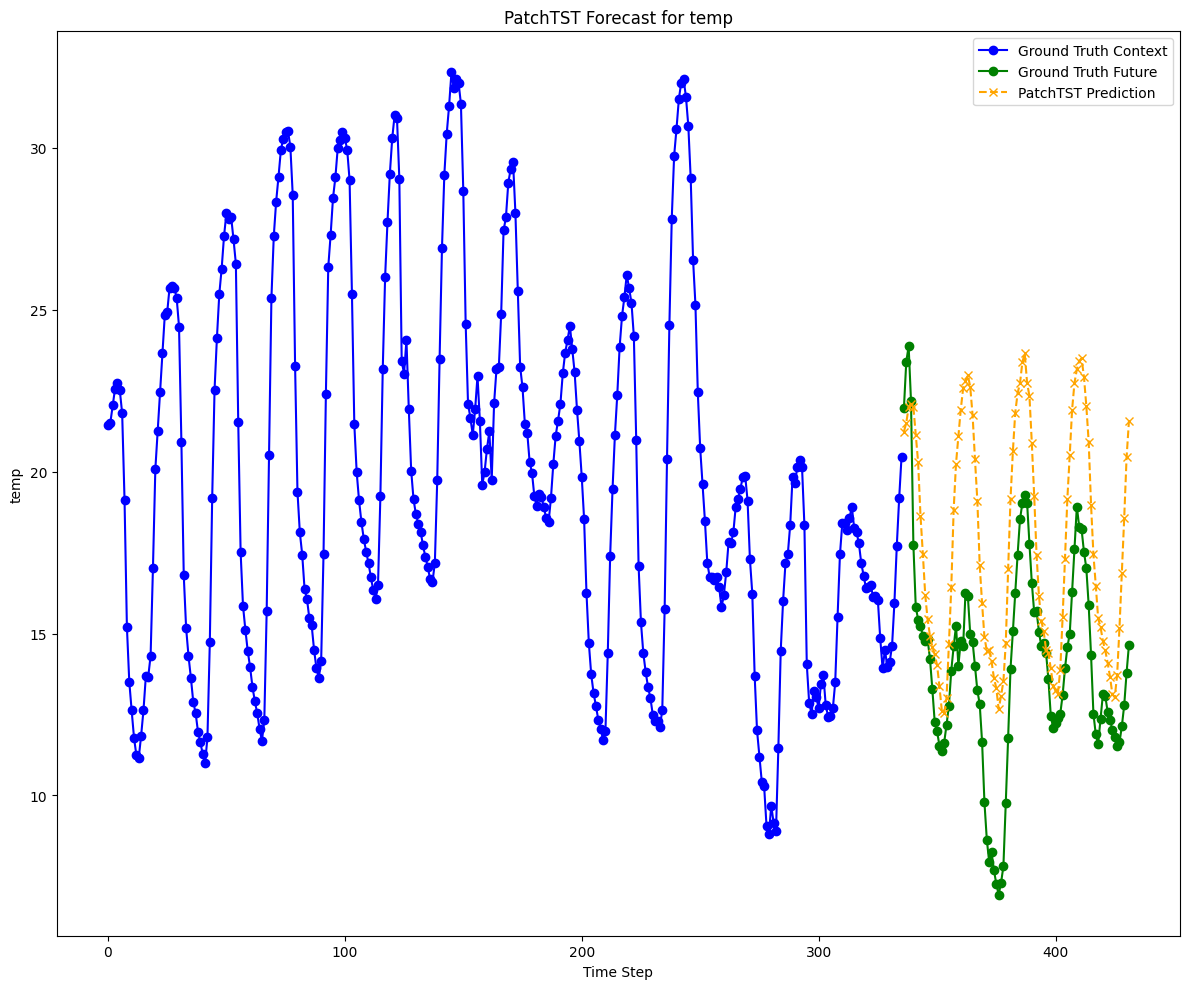

In [43]:
observable_columnss = ["temp"]
context_window = 336
prediction_horizon = 96

plt.figure(figsize=(12, 10))
num_variables = len(observable_columnss)
scaler_stats = {col: {'mean': data[col].mean(), 'std': data[col].std()} for col in observable_columnss}

for variable_idx in range(num_variables):
    sample_idx = 0
    # X_test_sample = X_test[sample_idx, :, variable_idx]
    # y_test_sample = y_test[sample_idx, :, variable_idx]

    # Inverse scale
    # context = X_test_sample * scaler_stats[observable_columnss[variable_idx]]['std'] + scaler_stats[observable_columnss[variable_idx]]['mean']
    # actual_future = y_test_sample * scaler_stats[observable_columnss[variable_idx]]['std'] + scaler_stats[observable_columnss[variable_idx]]['mean']
    context = test_dataset[sample_idx]['past_values'] * test_data['temp'].std() + test_data['temp'].mean()
    actual_future = test_dataset[sample_idx]['future_values'] * test_data['temp'].std() + test_data['temp'].mean()

    predicted_future = patchtst_predictions[sample_idx, :, variable_idx] *test_data['temp'].std() + test_data['temp'].mean()
    # print(f"act: {actual_future} \n pred {predicted_future}")
    # Plot
    plt.subplot(num_variables, 1, variable_idx + 1)

    plt.plot(range(context_window), context, label="Ground Truth Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), actual_future, label="Ground Truth Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future, label="PatchTST Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"PatchTST Forecast for {observable_columnss[variable_idx]}")
    plt.xlabel("Time Step")
    plt.ylabel(observable_columnss[variable_idx])
    plt.legend()

plt.tight_layout()
plt.show()

# Save context, actual, and predicted for each variable into a named file
np.savez(
    "PTST_results.npz",
    context=context,
    actual_future=actual_future,
    predicted_future=predicted_future,
    variable_column=observable_columnss
)


# Extra
If you want to load the custom sampled data from drive for plots comparability.

In [46]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
observable_columnss = ["temp"]#["no2", "temp", "o3", "no", "press"]
context_window = 336
prediction_horizon = 96
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# Please download the files and place them in content subfolder
# else modify below path according to your chosen local download path:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

with open("X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(observable_columns))  # (samples, 24*5)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(observable_columns))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(observable_columns))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(observable_columns))

scaler_stats = {col: {'mean': data[col].mean(), 'std': data[col].std()} for col in observable_columnss}

# Flatten input features
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(observable_columns))  # (samples, 24*5)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(observable_columns))
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1],  len(observable_columns))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(observable_columns))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [ ]:
raw_predictions = re_trainer.predict(X_test)
patchtst_predictions = raw_predictions.predictions
patchtst_predictions = patchtst_predictions[0]  # Extract the actual predictions array
patchtst_predictions.shape